<a href="https://colab.research.google.com/github/edwin-19/TransformersLatest/blob/main/LayoutLmV1_FineTune_PL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q datasets seqeval
!pip install pytorch_lightning

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data import DataLoader

from transformers import LayoutLMTokenizer, LayoutLMForTokenClassification
from datasets import load_dataset, load_metric
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
import numpy as np
from matplotlib import pyplot as plt

from datasets.features import ClassLabel
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

# Helper functions

In [3]:
def un_normalize_box(bbox, width, height):
  return [
    width * (bbox[0] / 1000),
    height * (bbox[1] / 1000),
    width * (bbox[2] / 1000),
    height * (bbox[3] / 1000)
  ]

In [4]:
class InputFeatures(object):
     """A single set of features of data."""
     def __init__(
        self,
        input_ids,
        attention_mask,
        token_type_ids,
        labels,
        bbox,
    ):
        assert (
            0 <= all(bbox) <= 1000
        ), "Error with input bbox ({}): the coordinate value is not between 0 and 1000".format(
            bbox
        )
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.token_type_ids = token_type_ids
        self.labels = labels
        self.bbox = bbox
        
def convert_example_to_features(
    image, labels, words, boxes, actual_boxes, tokenizer, 
    max_seq_length=512,
    cls_token_at_end=False,
    cls_token="[CLS]",
    cls_token_segment_id=1,
    sep_token="[SEP]",
    sep_token_extra=False,
    pad_on_left=False,
    pad_token=0,
    cls_token_box=[0, 0, 0, 0],
    sep_token_box=[1000, 1000, 1000, 1000],
    pad_token_box=[0, 0, 0, 0],
    pad_token_segment_id=0,
    pad_token_label_id=-1,
    sequence_a_segment_id=0,
    mask_padding_with_zero=True,
) -> InputFeatures:
    """
    Convert image, text and bounding box to the relevant features for layoutlm processing
    
    args:

        
    returns:

    """
    width, height = image.size
    
    tokens = []
    token_boxes = []
    actual_bboxes = []
    label_ids = []
    
    for word, label, box, actual_bbox in zip(words, labels, boxes, actual_boxes):
        word_tokens = tokenizer.tokenize(word)
        tokens.extend(word_tokens)
        token_boxes.extend([box] * len(word_tokens))
        actual_bboxes.extend([actual_bbox] * len(word_tokens))
        
        # Use the real label id for the first token of the word, and padding ids for the remaining tokens
        label_ids.extend(
            [label] + [pad_token_label_id] * (len(word_tokens) - 1)
        )
        
    # Truncation: account for [CLS] and [SEP] with "- 2". 
    special_tokens_count = 2
    if len(tokens) > max_seq_length - special_tokens_count:
        tokens = tokens[: (max_seq_length - special_tokens_count)]
        token_boxes = token_boxes[: (max_seq_length - special_tokens_count)]
        actual_bboxes = actual_bboxes[: (max_seq_length - special_tokens_count)]
        label_ids = label_ids[:(max_seq_length - special_tokens_count)]
        
    # add [SEP] token, with corresponding token boxes and actual boxes
    tokens += [tokenizer.sep_token]
    token_boxes += [sep_token_box]
    actual_bboxes += [[0, 0, width, height]]
    label_ids += [pad_token_label_id]
    if sep_token_extra:
        # roberta uses an extra separator b/w pairs of sentences
        tokens += [sep_token]
        token_boxes += [sep_token_box]
        actual_bboxes += [[0, 0, width, height]]
        label_ids += [pad_token_label_id]
    
    segment_ids = [sequence_a_segment_id] * len(tokens)
    
    # next: [CLS] token
    if cls_token_at_end:
        tokens += [cls_token]
        token_boxes += [cls_token_box]
        actual_bboxes += [[0, 0, width, height]]
        label_ids += [pad_token_label_id]
        segment_ids += [cls_token_segment_id]
    else:
        tokens = [cls_token] + tokens
        token_boxes = [cls_token_box] + token_boxes
        actual_bboxes = [[0, 0, width, height]] + actual_bboxes
        label_ids = [pad_token_label_id] + label_ids
        segment_ids = [cls_token_segment_id] + segment_ids

    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    
    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1 if mask_padding_with_zero else 0] * len(input_ids)
    
    # Zero-pad up to the sequence length.
    padding_length = max_seq_length - len(input_ids)
    if pad_on_left:
        input_ids = ([pad_token] * padding_length) + input_ids
        input_mask = (
            [0 if mask_padding_with_zero else 1] * padding_length
        ) + input_mask
        segment_ids = ([pad_token_segment_id] * padding_length) + segment_ids
        label_ids = ([pad_token_label_id] * padding_length) + label_ids
        token_boxes = ([pad_token_box] * padding_length) + token_boxes
    else:
        input_ids += [pad_token] * padding_length
        input_mask += [0 if mask_padding_with_zero else 1] * padding_length
        segment_ids += [pad_token_segment_id] * padding_length
        label_ids += [pad_token_label_id] * padding_length
        token_boxes += [pad_token_box] * padding_length

    if len(label_ids) > max_seq_length:
        del label_ids[-1]

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length
    assert len(label_ids) == max_seq_length, (label_ids, words)
    assert len(token_boxes) == max_seq_length

    return InputFeatures(
        input_ids=input_ids,
        attention_mask=input_mask,
        token_type_ids=segment_ids,
        labels=label_ids,
        bbox=token_boxes
    )

# Used for converting features for infer
def convert_features(
    image, words, boxes, actual_boxes, tokenizer,
    max_seq_length=512, cls_token_box=[0, 0, 0, 0],
    sep_token_box=[1000, 1000, 1000, 1000],
    pad_token_box=[0, 0, 0, 0],
):
    width, height = image.size

    tokens = []
    token_boxes = []
    actual_bboxes = [] # we use an extra b because actual_boxes is already used
    token_actual_boxes = []
    for word, box, actual_bbox in zip(words, boxes, actual_boxes):
        word_tokens = tokenizer.tokenize(word)
        tokens.extend(word_tokens)
        token_boxes.extend([box] * len(word_tokens))
        actual_bboxes.extend([actual_bbox] * len(word_tokens))
        token_actual_boxes.extend([actual_bbox] * len(word_tokens))

    # Truncation: account for [CLS] and [SEP] with "- 2". 
    special_tokens_count = 2 
    if len(tokens) > max_seq_length - special_tokens_count:
        tokens = tokens[: (max_seq_length - special_tokens_count)]
        token_boxes = token_boxes[: (max_seq_length - special_tokens_count)]
        actual_bboxes = actual_bboxes[: (max_seq_length - special_tokens_count)]
        token_actual_boxes = token_actual_boxes[: (max_seq_length - special_tokens_count)]

    # add [SEP] token, with corresponding token boxes and actual boxes
    tokens += [tokenizer.sep_token]
    token_boxes += [sep_token_box]
    actual_bboxes += [[0, 0, width, height]]
    token_actual_boxes += [[0, 0, width, height]]
    
    segment_ids = [0] * len(tokens)

    # next: [CLS] token
    tokens = [tokenizer.cls_token] + tokens
    token_boxes = [cls_token_box] + token_boxes
    actual_bboxes = [[0, 0, width, height]] + actual_bboxes
    token_actual_boxes = [[0, 0, width, height]] + token_actual_boxes
    segment_ids = [1] + segment_ids

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    padding_length = max_seq_length - len(input_ids)
    input_ids += [tokenizer.pad_token_id] * padding_length
    input_mask += [0] * padding_length
    segment_ids += [tokenizer.pad_token_id] * padding_length
    token_boxes += [pad_token_box] * padding_length
    token_actual_boxes += [pad_token_box] * padding_length

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length
    #assert len(label_ids) == max_seq_length
    assert len(token_boxes) == max_seq_length
    assert len(token_actual_boxes) == max_seq_length
    
    return input_ids, input_mask, segment_ids, token_boxes, token_actual_boxes

# Load dataset

In [5]:
pl.seed_everything(42)

Global seed set to 42


42

In [6]:
# this dataset uses the new Image feature :)
dataset = load_dataset("nielsr/funsd-layoutlmv3")

Reusing dataset funsd (/root/.cache/huggingface/datasets/nielsr___funsd/funsd/1.0.0/0e3f4efdfd59aa1c3b4952c517894f7b1fc4d75c12ef01bcc8626a69e41c1bb9)


  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
tokenizer = LayoutLMTokenizer.from_pretrained("microsoft/layoutlm-base-uncased")

In [8]:
metric = load_metric("seqeval")

In [9]:
features = dataset["train"].features
column_names = dataset["train"].column_names
image_column_name = "image"
text_column_name = "tokens"
boxes_column_name = "bboxes"
label_column_name = "ner_tags"

if isinstance(features[label_column_name].feature, ClassLabel):
    label_list = features[label_column_name].feature.names
    # No need to convert the labels since they are already ints.
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}

num_labels = len(label_list)
pad_token_label_id = torch.nn.CrossEntropyLoss().ignore_index

In [10]:
def prepare_examples(example):
  image = example[image_column_name]
  width, height = image.size

  words = example[text_column_name]
  boxes = example[boxes_column_name]
  actual_boxes = [un_normalize_box(box, width, height) for box in boxes]
  word_labels = example[label_column_name]

  input_features = convert_example_to_features(
      image=image, labels=word_labels, words=words, boxes=boxes, actual_boxes=actual_boxes,
      pad_token_label_id=pad_token_label_id,
      tokenizer=tokenizer, max_seq_length=512
  )

  return input_features.__dict__

In [11]:
features = Features({
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'token_type_ids': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(ClassLabel(names=label_list)),
})

train_dataset = dataset['train'].map(
    prepare_examples,
    batched=False,
    remove_columns=column_names,
    features=features,
)

eval_dataset = dataset['test'].map(
    prepare_examples,
    batched=False,
    remove_columns=column_names,
    features=features,
)

Loading cached processed dataset at /root/.cache/huggingface/datasets/nielsr___funsd/funsd/1.0.0/0e3f4efdfd59aa1c3b4952c517894f7b1fc4d75c12ef01bcc8626a69e41c1bb9/cache-7702da3b08fa64b2.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/nielsr___funsd/funsd/1.0.0/0e3f4efdfd59aa1c3b4952c517894f7b1fc4d75c12ef01bcc8626a69e41c1bb9/cache-39052beb44ba2167.arrow


In [12]:
example = train_dataset[0]
tokenizer.decode(example['input_ids'])

'[CLS] r & d : suggestion : date : licensee yes no 597005708 r & d quality improvement suggestion / solution form name / phone ext. : m. hamann p. harper, p. martinez 9 / 3 / 92 r & d group : j. s. wigand supervisor / manager discontinue coal retention analyses on licensee submitted product samples ( note : coal retention testing is not performed by most licensees. other b & w physical measurements as ends stability and inspection for soft spots in ciparettes are thought to be sufficient measures to assure cigarette physical integrity. the proposed action will increase laboratory productivity. ) suggested solutions ( s ) : delete coal retention from the list of standard analyses performed on licensee submitted product samples. special requests for coal retention testing could still be submitted on an exception basis. have you contacted your manager / supervisor? manager comments : manager, please contact suggester and forward comments to the quality council. qip. wp [SEP] [PAD] [PAD] [

In [13]:
train_dataset.set_format("torch")
eval_dataset.set_format("torch")

In [14]:
example = train_dataset[0]
for k,v in example.items():
    print(k,v.shape)

input_ids torch.Size([512])
attention_mask torch.Size([512])
token_type_ids torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])


# Built Lightning DataModule

In [15]:
class FunsdDataMoudule(pl.LightningDataModule):
  def __init__(
      self, train_dataset, eval_dataset,
      batch_size:int=32
  ):
    super(FunsdDataMoudule, self).__init__()
    self.train_dataset = train_dataset
    self.eval_dataset = eval_dataset
    self.batch_size = batch_size

  def train_dataloader(self) -> DataLoader:
    return DataLoader(
        self.train_dataset, pin_memory=True,
        shuffle=True, batch_size=self.batch_size,
        num_workers=2
    )

  def val_dataloader(self) -> DataLoader:
    return DataLoader(
        self.eval_dataset, pin_memory=True,
        shuffle=False, batch_size=self.batch_size,
        num_workers=2
    )

In [16]:
datamodule = FunsdDataMoudule(train_dataset, eval_dataset, batch_size=8)

# Build Ligthning Module

In [17]:
class LayoutLmLightningModule(pl.LightningModule):
  def __init__(self, model, lr=5e-5):
    super(LayoutLmLightningModule, self).__init__()

    self.model = model
    self.lr = lr

  def forward(self, input_ids, attention_mask,token_type_ids, bbox, labels=None):
    return self.model(
        input_ids=input_ids,
        bbox=bbox,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids,
        labels=labels,
    )

  def training_step(self, batch, batch_idx):
    outputs = self(**batch)
    label = batch['labels']

    loss = outputs.loss
    logits = outputs.logits

    return loss

  def validation_step(self, batch, batch_idx):
    outputs = self(**batch)
    label = batch['labels']
    
    val_loss = outputs.loss
    logits = outputs.logits

    results = self.compute_metrics(logits, label)

    self.log('val_acc', results['accuracy'], prog_bar=True, logger=True)
    self.log('val_f1', results['f1'], prog_bar=True, logger=True)

    return val_loss

  def test_step(self, batch, batch_idx):
    outputs = self(**batch)
    label = batch['labels']
    
    val_loss = outputs.loss
    logits = outputs.logits

    results = self.compute_metrics(logits, label)

    self.log('test_acc', results['accuracy'], prog_bar=True, logger=True)
    self.log('test_f1', results['f1'], prog_bar=True, logger=True)
    self.log('test_recall', results['recall'], prog_bar=True, logger=True)
    self.log('test_precision', results['precision'], prog_bar=True, logger=True)

  def compute_metrics(self, predictions:torch.Tensor, labels:torch.Tensor) -> dict:
    predictions = predictions.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()

    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

  def configure_optimizers(self):
      return {
          'optimizer': torch.optim.AdamW(self.parameters(), lr=self.lr)
      }

In [18]:
model = LayoutLMForTokenClassification.from_pretrained("microsoft/layoutlm-base-uncased", num_labels=num_labels)

Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft

In [19]:
layout_module = LayoutLmLightningModule(model, lr=5e-5)

# Trainer and Fit

In [20]:
early_stopping = pl.callbacks.EarlyStopping(
    monitor='val_f1',
    min_delta=0.02,
    patience=3,
    verbose=False,
    mode='max'
)

trainer = pl.Trainer(
    max_epochs=9,
    accelerator='gpu', devices=1,
    callbacks=[early_stopping]
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [21]:
trainer.fit(layout_module, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                           | Params
---------------------------------------------------------
0 | model | LayoutLMForTokenClassification | 112 M 
---------------------------------------------------------
112 M     Trainable params
0         Non-trainable params
112 M     Total params
450.533   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1937: PossibleUserWarning: The number of training batches (19) is smaller than the

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [22]:
trainer.test(layout_module, datamodule.val_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7991865277290344
         test_f1            0.8496040709263265
     test_precision         0.8420556419726638
       test_recall          0.8581241442632888
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.7991865277290344,
  'test_f1': 0.8496040709263265,
  'test_precision': 0.8420556419726638,
  'test_recall': 0.8581241442632888}]

In [23]:
!nvidia-smi

Sun Jun  5 08:56:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    32W /  70W |   1430MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Inference

In [24]:
layout_module.eval()
layout_module.cuda();

In [25]:
test_example = np.random.choice(dataset['test'])

image = test_example['image']
width, height = image.size 

words = test_example['tokens']
boxes = test_example['bboxes']
actual_boxes = [un_normalize_box(box, width, height) for box in boxes]

input_ids, input_mask, segment_ids, token_boxes, token_actual_boxes = convert_features(
    image, words, boxes, actual_boxes, tokenizer,
)

encoding = {
    'input_ids': torch.tensor(input_ids, device='cuda').unsqueeze(0),
    'attention_mask': torch.tensor(input_mask, device='cuda').unsqueeze(0),
    'token_type_ids': torch.tensor(segment_ids, device='cuda').unsqueeze(0),
    'bbox': torch.tensor(token_boxes, device='cuda').unsqueeze(0),
}

with torch.no_grad():
  outputs = layout_module(**encoding)

In [26]:
outputs.logits

tensor([[[-0.0312,  0.7140,  0.3830,  ..., -0.9284, -0.3030, -0.0655],
         [ 6.3751, -0.7549, -1.6122,  ..., -1.0802, -0.9374, -0.7006],
         [ 5.9038, -1.8142, -1.3132,  ..., -0.3077, -1.5390,  0.0473],
         ...,
         [ 2.8722, -1.3094, -1.7092,  ..., -0.1292, -0.3396, -2.0051],
         [ 3.1368, -0.8233, -2.1106,  ..., -1.1626,  0.1491, -1.5380],
         [ 3.7491, -0.5026, -1.9839,  ..., -1.0728, -0.5291, -1.6029]]],
       device='cuda:0')

In [27]:
predictions = outputs.logits.argmax(-1).squeeze().tolist()
print(predictions)

[1, 0, 0, 0, 0, 3, 4, 3, 3, 3, 0, 1, 2, 2, 3, 4, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 4, 5, 6, 6, 6, 6, 6, 3, 4, 5, 6, 6, 6, 3, 4, 4, 4, 5, 6, 6, 6, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 6, 6, 6, 6, 3, 4, 4, 4, 3, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 5, 6, 5, 6, 6, 6, 6, 5, 6, 6, 6, 6, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 3, 3, 5, 5, 5, 3, 5, 5, 3, 3, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [28]:
image = test_example['image']

width, height = image.size

word_level_predictions = [] # let's turn them into word level predictions
final_words = []
final_boxes = []
for id, token_pred, box in zip(input_ids, predictions, token_actual_boxes):
    if (tokenizer.decode([id]).startswith("##")) or (id in [tokenizer.cls_token_id, 
                                                        tokenizer.sep_token_id, 
                                                        tokenizer.pad_token_id]):
        # skip prediction + bounding box
        continue
    else:
        word_level_predictions.append(id2label[token_pred])
        final_words.append(tokenizer.decode([id]))
        final_boxes.append(box)

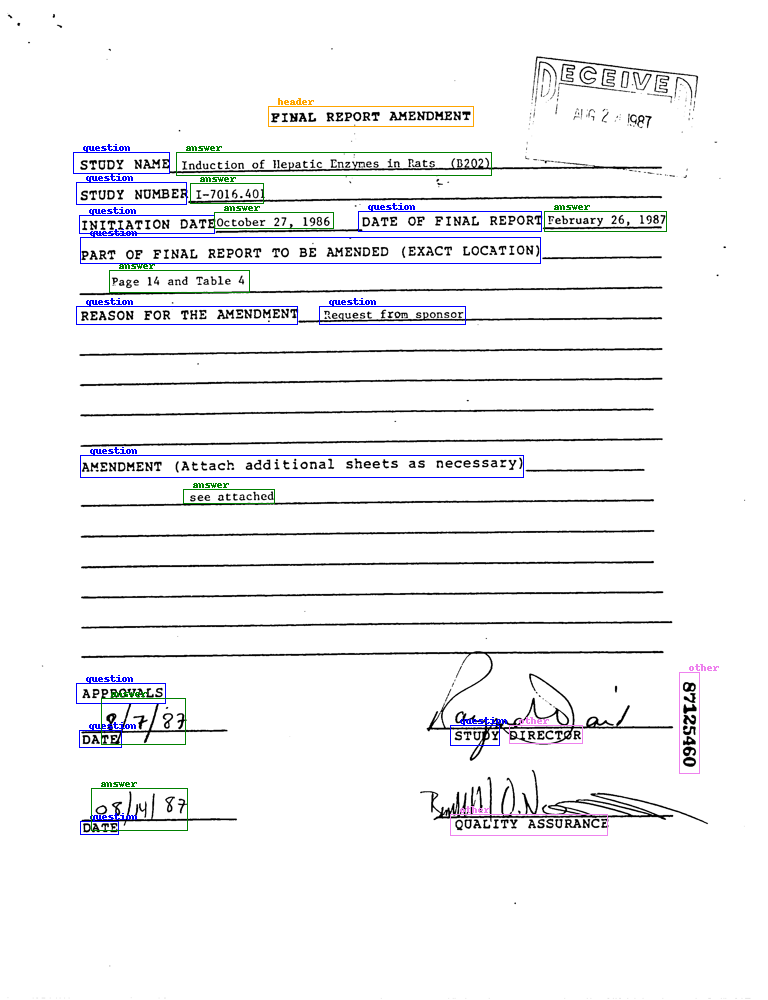

In [29]:
draw = ImageDraw.Draw(image)
font = ImageFont.load_default()

def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'other'
    return label

label2color = {'question':'blue', 'answer':'green', 'header':'orange', 'other':'violet'}

for prediction, box in zip(word_level_predictions, final_boxes):
    predicted_label = iob_to_label(prediction).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

image